### 一.模型结构
线性回归算是回归任务中比较简单的一种模型，它的模型结构可以表示如下：   

$$
f(x)=w^Tx^*
$$  
这里$x^*=[x^T,1]^T$，$x\in R^n$，所以$w\in R^{n+1}$，$w$即是模型需要学习的参数，下面造一些伪数据进行演示：

In [15]:
import numpy as np
#造伪样本
X=np.linspace(0,100,100)
X=np.c_[X,np.ones(100)]
w=np.asarray([3,2])
Y=X.dot(w)
X=X.astype('float')
Y=Y.astype('float')
X[:,0]+=np.random.normal(size=(X[:,0].shape))*3#添加噪声

In [16]:
Y=Y.reshape(100,1)

Text(0, 0.5, 'Y')

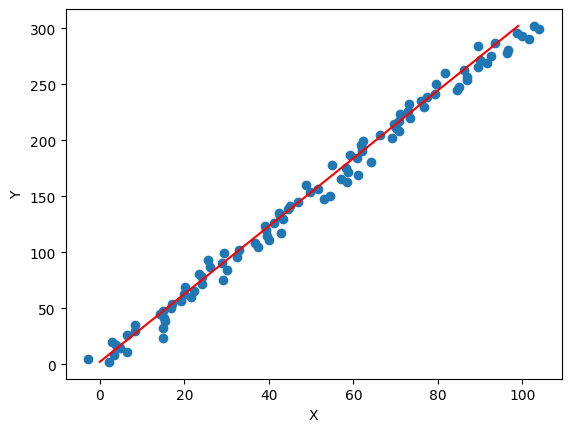

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(X[:,0],Y)
plt.plot(np.arange(0,100).reshape((100,1)),Y,'r')
plt.xlabel('X')
plt.ylabel('Y')

### 二.损失函数
利用等式$y=3x+2$我造了一些伪数据，并给$x$添加了一些噪声数据，线性回归的目标即在只有$x,y$的情况下，求解出最优解：$w=[3,2]^T$；可以通过MSE（均方误差）来衡量$f(x)$与$y$的相近程度：  

$$
L(w)=\sum_{i=1}^m(y_i-f(x_i))^2=\sum_{i=1}^m(y_i-w^Tx_i^*)^2=(Y-X^*w)^T(Y-X^*w)
$$  

这里$m$表示样本量，本例中$m=100$，$x_i,y_i$表示第$i$个样本，$X^*\in R^{m \times (n+1)},Y\in R^{m\times 1}$，损失函数$L(w)$本质上是关于$w$的函数，通过求解最小的$L(w)$即可得到$w$的最优解：

$$
w^*=arg \min_{w}L(w)
$$


#### 方法一：直接求闭式解

而对$\min L(w)$的求解很明显是一个凸问题（海瑟矩阵${X^*}^TX^*$正定），我们可以直接通过求解$\frac{dL}{dw}=0$得到$w^*$，梯度推导如下：  

$$
\frac{dL}{dw}=-2\sum_{i=1}^m(y_i-w^Tx_i^*)x_i^*=-2{X^*}^T(Y-X^*w)\\
$$  
令$\frac{dL}{dw}=0$，可得：$w^*=({X^*}^TX^*)^{-1}{X^*}^TY$，实际情景中数据不一定能满足${X^*}^TX$是满秩（比如$m<n$的情况下，$w$的解有无数种），所以没法直接求逆，我们可以考虑用如下的方式求解：
$$
{X^*}^+=\lim_{\alpha\rightarrow0}({X^*}^TX^*+\alpha I)^{-1}{X^*}^T
$$  

上面的公式即是Moore-Penrose伪逆的定义，但实际求解更多是通过SVD的方式：  

$$
{X^*}^+=VD^+U^T
$$  

其中，$U,D,V$是矩阵$X^*$做奇异值分解（SVD）后得到的矩阵，对角矩阵$D$的伪逆$D^+$由其非零元素取倒数之后再转置得到，通过伪逆求解到的结果有如下优点：  

（1）当$w$有解时，$w^*={X^*}^+Y$是所有解中欧几里得距离$||w||_2$最小的一个；    

（2）当$w$无解时，通过伪逆得到的$w^*$是使得$X^*w^*$与$Y$的欧几里得距离$||X^*w^*-Y||_2$最小  

#### 方法二：梯度下降求解

但对于数据量很大的情况，求闭式解的方式会让内存很吃力，我们可以通过随机梯度下降法（SGD）对$w$进行更新，首先随机初始化$w$，然后使用如下的迭代公式对$w$进行迭代更新：  
$$
w:=w-\eta\frac{dL}{dw}
$$  
### 三.模型训练
目前我们推导出了$w$的更新公式，接下来编码训练过程：

In [18]:
#参数初始化
w=np.random.random(size=(2,1))
#更新参数
epoches=100
eta=0.0000001
losses=[]#记录loss变化
for _ in range(epoches):
    dw=-2*X.T.dot(Y-X.dot(w))
    w=w-eta*dw
    losses.append((Y-X.dot(w)).T.dot(Y-X.dot(w)).reshape(-1))
w

array([[2.99133694],
       [0.37318084]])

Text(0, 0.5, 'Y')

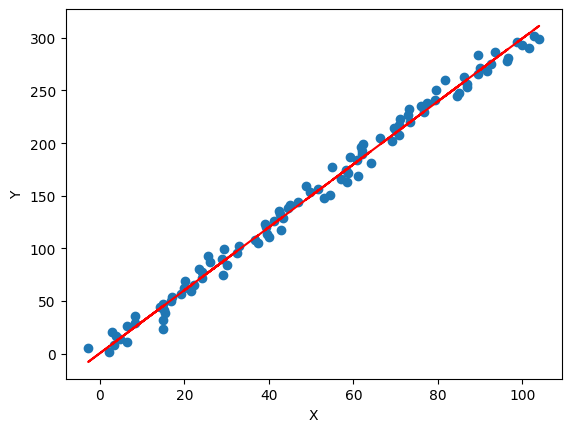

In [19]:
#可视化
plt.scatter(X[:,0],Y)
plt.plot(X[:,0],X.dot(w),'r')
plt.xlabel('X')
plt.ylabel('Y')

Text(0, 0.5, 'loss')

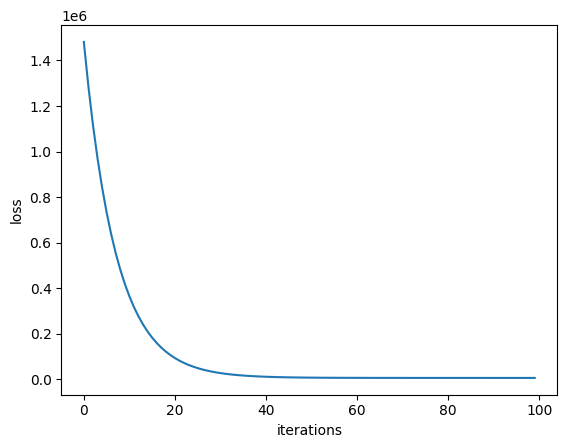

In [20]:
#loss变化
plt.plot(losses)
plt.xlabel('iterations')
plt.ylabel('loss')

In [21]:
#当然也可以直接求显式解
w=np.linalg.pinv(X).dot(Y)
w

array([[2.96712757],
       [2.13690755]])

Text(0, 0.5, 'Y')

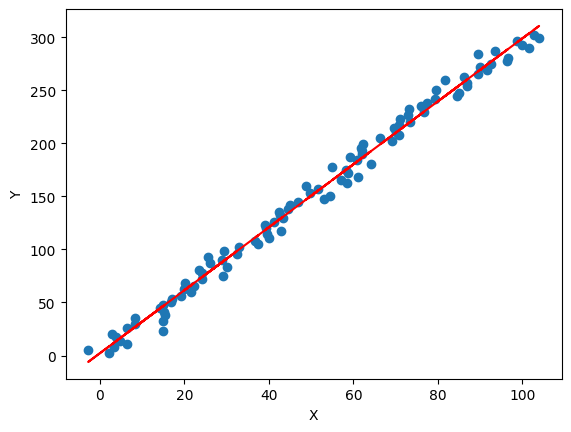

In [22]:
#可视化
plt.scatter(X[:,0],Y)
plt.plot(X[:,0],X.dot(w),'r')
plt.xlabel('X')
plt.ylabel('Y')

### 四.问题讨论
在上面的梯度下降的例子中存在一个问题，$w_1$基本能收敛到3附近，而$w_2$却基本在0附近，很难收敛到2，说明$w_1$比$w_2$更容易收敛($w=[w_1,w_2]^T$)，这很容易理解，模型可以写作：$f(x)=x*w_1+1\cdot w_2$，如果$x$量纲比1大很多，为了使$f(x)$变化，只需更新少量的$w_1$就能达到目的，而$w_2$的更新动力略显不足；可以考虑用如下方式：  

（1）对输入$X$进行归一化，使得$x$无量纲，$w_1,w_2$的更新动力一样（后面封装代码时添加上），如下图；
![avatar](./source/01_归一化对梯度下降的影响.png)

（2）梯度更新时，$w_1,w_2$使用了一样的学习率，可以让$w_1,w_2$使用不一样的学习率进行更新，比如对$w_2$使用更大的学习率进行更新（可以利用学习率自适应一类的梯度下降法，比如adam），如下图：  
![avatar](./source/01_adam.png)
### 五.封装与测试
接下来简单封装线性回归模型，并放到ml_models.linear_model模块便于后续使用；

In [23]:
class LinearRegression(object):
    def __init__(self, fit_intercept=True, solver='sgd', if_standard=True, epochs=10, eta=1e-2, batch_size=1):
        """
        :param fit_intercept: 是否训练bias
        :param solver:
        :param if_standard:
        """
        self.w = None
        self.fit_intercept = fit_intercept
        self.solver = solver
        self.if_standard = if_standard
        if if_standard:
            self.feature_mean = None
            self.feature_std = None
        self.epochs = epochs
        self.eta = eta
        self.batch_size = batch_size

    def init_params(self, n_features):
        """
        初始化参数
        :return:
        """
        self.w = np.random.random(size=(n_features, 1))

    def _fit_closed_form_solution(self, x, y):
        """
        直接求闭式解
        :param x:
        :param y:
        :return:
        """
        self.w = np.linalg.pinv(x).dot(y)

    def _fit_sgd(self, x, y):
        """
        随机梯度下降求解
        :param x:
        :param y:
        :param epochs:
        :param eta:
        :param batch_size:
        :return:
        """
        x_y = np.c_[x, y]
        # 按batch_size更新w,b
        for _ in range(self.epochs):
            np.random.shuffle(x_y)
            for index in range(x_y.shape[0] // self.batch_size):
                batch_x_y = x_y[self.batch_size * index:self.batch_size * (index + 1)]
                batch_x = batch_x_y[:, :-1]
                batch_y = batch_x_y[:, -1:]

                dw = -2 * batch_x.T.dot(batch_y - batch_x.dot(self.w)) / self.batch_size
                self.w = self.w - self.eta * dw

    def fit(self, x, y):
        # 是否归一化feature
        if self.if_standard:
            self.feature_mean = np.mean(x, axis=0)
            self.feature_std = np.std(x, axis=0) + 1e-8
            x = (x - self.feature_mean) / self.feature_std
        # 是否训练bias
        if self.fit_intercept:
            x = np.c_[x, np.ones_like(y)]
        # 初始化参数
        self.init_params(x.shape[1])
        # 训练模型
        if self.solver == 'closed_form':
            self._fit_closed_form_solution(x, y)
        elif self.solver == 'sgd':
            self._fit_sgd(x, y)

    def get_params(self):
        """
        输出原始的系数
        :return: w,b
        """
        if self.fit_intercept:
            w = self.w[:-1]
            b = self.w[-1]
        else:
            w = self.w
            b = 0
        if self.if_standard:
            w = w / self.feature_std.reshape(-1, 1)
            b = b - w.T.dot(self.feature_mean.reshape(-1, 1))
        return w.reshape(-1), b

    def predict(self, x):
        """
        :param x:ndarray格式数据: m x n
        :return: m x 1
        """
        if self.if_standard:
            x = (x - self.feature_mean) / self.feature_std
        if self.fit_intercept:
            x = np.c_[x, np.ones(shape=x.shape[0])]
        return x.dot(self.w)

    def plot_fit_boundary(self, x, y):
        """
        绘制拟合结果
        :param x:
        :param y:
        :return:
        """
        plt.scatter(x[:, 0], y)
        plt.plot(x[:, 0], self.predict(x), 'r')

In [24]:
#测试
lr=LinearRegression(solver='sgd')
lr.fit(X[:,:-1],Y)
predict=lr.predict(X[:,:-1])
#查看w
print('w',lr.get_params())
#查看标准差
np.std(Y-predict)

w (array([2.98653395]), array([[1.25053246]]))


7.995063551392363

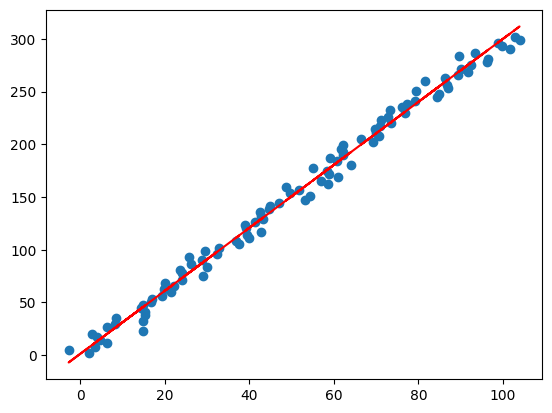

In [25]:
#可视化结果
lr.plot_fit_boundary(X[:,:-1],Y)

In [26]:
#测试
lr=LinearRegression(solver='closed_form')
lr.fit(X[:,:-1],Y)
predict=lr.predict(X[:,:-1])
#查看w
print('w',lr.get_params())
#查看标准差
np.std(Y-predict)

w (array([2.96712757]), array([[2.13690755]]))


7.9747381115429645

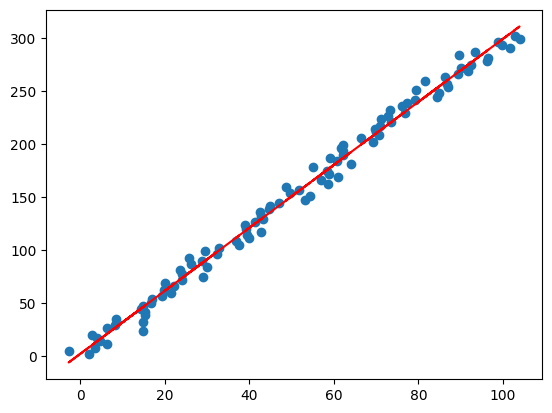

In [27]:
#可视化结果
lr.plot_fit_boundary(X[:,:-1],Y)

In [28]:
#与sklearn对比
from sklearn.linear_model import LinearRegression
lr=LinearRegression()
lr.fit(X[:,:-1],Y)
predict=lr.predict(X[:,:-1])
#查看w,b
print('w:',lr.coef_,'b:',lr.intercept_)
#查看标准差
np.std(Y-predict)

w: [[2.96712757]] b: [2.13690755]


7.974738111542963